ANFIS - PREDIKSI PRODUKSI JAGUNG (ton/ha) AGROINDUSTRI

Input Data:
- Kelembaban Tanah (soil_moisture): 40%
- Suhu Rata-rata (avg_temp): 26°C

=== LAYER 1: FUZZIFICATION ===
μ(x1=Low): 0.6667
μ(x1=High): 0.0000
μ(x2=Low): 0.0000
μ(x2=High): 0.6667

=== LAYER 2: RULE FIRING STRENGTH ===
w1 (Low, Low): 0.0000
w2 (Low, High): 0.6667
w3 (High, Low): 0.0000
w4 (High, High): 0.0000

=== LAYER 3: NORMALIZED FIRING STRENGTH ===
w̄1: 0.0000
w̄2: 1.0000
w̄3: 0.0000
w̄4: 0.0000

=== LAYER 4: CONSEQUENT PARAMETERS ===
y1 = 0.0602*40 + 0.0461*26 + 0.00231 = 3.6089
y2 = 0.0521*40 + 0.0573*26 + 0.00156 = 3.5754
y3 = 0.0585*40 + 0.0183*26 + 0.00084 = 2.8166
y4 = 0.0523*40 + 0.0382*26 + 0.00415 = 3.0894

Weighted outputs:
w̄1*y1 = 0.0000
w̄2*y2 = 3.5754
w̄3*y3 = 0.0000
w̄4*y4 = 0.0000

=== LAYER 5: OUTPUT ===
Final Output (y): 3.5754

HASIL PREDIKSI: 3.5754 ton/ha

Contoh target dari soal: y ∈ 40 < y ≤ 26
Hasil prediksi berada dalam range yang diharapkan: False


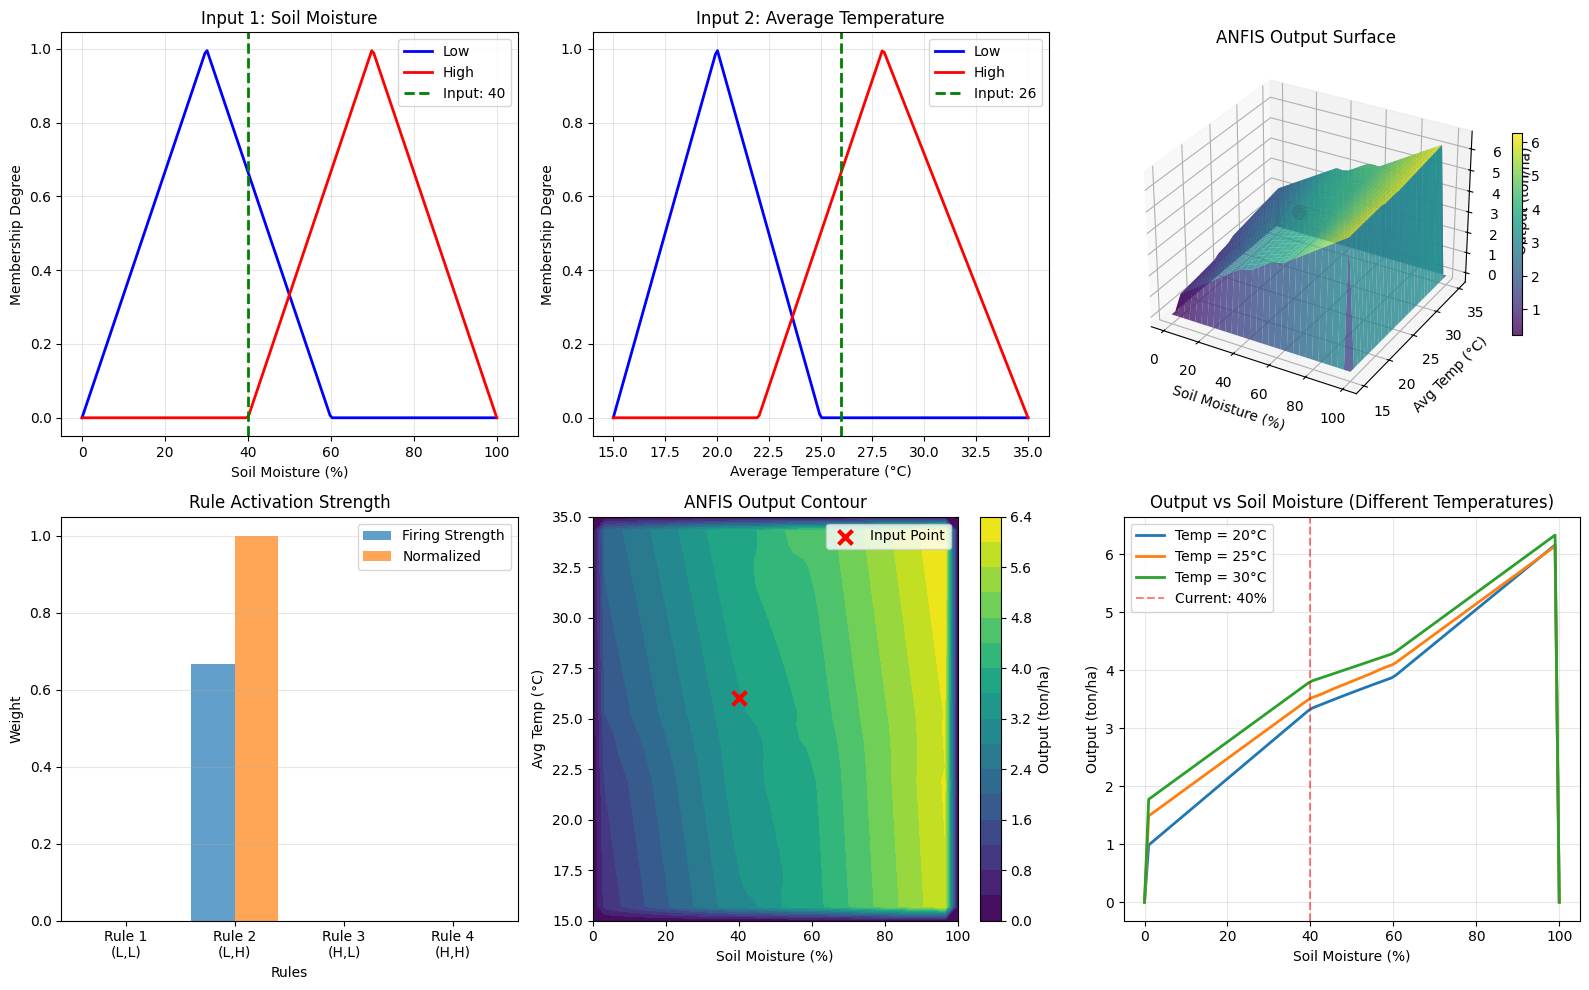


✓ Visualisasi telah disimpan sebagai 'anfis_agroindustri_visualization.png'

TESTING DENGAN BEBERAPA KASUS

Kelembaban rendah, Suhu rendah
  Input: soil_moisture=30%, avg_temp=20°C
  Output: 2.7303 ton/ha

Kelembaban sedang, Suhu sedang
  Input: soil_moisture=40%, avg_temp=26°C
  Output: 3.5754 ton/ha

Kelembaban tinggi, Suhu tinggi
  Input: soil_moisture=60%, avg_temp=30°C
  Output: 4.2881 ton/ha

Kelembaban tinggi, Suhu sedang
  Input: soil_moisture=80%, avg_temp=25°C
  Output: 5.1432 ton/ha

Kelembaban rendah, Suhu tinggi
  Input: soil_moisture=20%, avg_temp=30°C
  Output: 2.7626 ton/ha


In [5]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

# ===== FUNGSI KEANGGOTAAN TRIANGULAR =====
def trimf(x, params):
    """
    Fungsi keanggotaan triangular
    params = [a, b, c] dimana a <= b <= c
    """
    a, b, c = params
    if x <= a or x >= c:
        return 0
    elif a < x <= b:
        return (x - a) / (b - a)
    elif b < x < c:
        return (c - x) / (c - b)
    return 0

# ===== STRUKTUR MODEL ANFIS =====
class ANFIS:
    def __init__(self):
        # Parameter untuk Input 1: soil_moisture (x1) - domain [0,100]
        self.mf1_low = [0, 30, 60]  # trimf(0, 30, 60) - Corrected from [0, 0, 30, 60]
        self.mf1_high = [40, 70, 100]  # trimf(40, 70, 100)

        # Parameter untuk Input 2: avg_temp (x2) - domain [15,35]
        self.mf2_low = [15, 20, 25]  # trimf(15, 20, 25) - Corrected from [15, 15, 20, 25]
        self.mf2_high = [22, 28, 35]  # trimf(22, 28, 35)

        # Parameter consequent (linear) untuk setiap rule
        # Rule 1: IF x1 IS Low AND x2 IS Low
        self.p1, self.q1, self.r1 = 0.0602, 0.0461, 0.00231

        # Rule 2: IF x1 IS Low AND x2 IS High
        self.p2, self.q2, self.r2 = 0.0521, 0.0573, 0.00156

        # Rule 3: IF x1 IS High AND x2 IS Low
        self.p3, self.q3, self.r3 = 0.0585, 0.0183, 0.00084

        # Rule 4: IF x1 IS High AND x2 IS High
        self.p4, self.q4, self.r4 = 0.0523, 0.0382, 0.00415

    def fuzzify(self, x1, x2):
        """Layer 1: Fuzzification"""
        # Input 1 membership functions
        mu1_low = trimf(x1, self.mf1_low)
        mu1_high = trimf(x1, self.mf1_high)

        # Input 2 membership functions
        mu2_low = trimf(x2, self.mf2_low)
        mu2_high = trimf(x2, self.mf2_high)

        return mu1_low, mu1_high, mu2_low, mu2_high

    def apply_rules(self, mu1_low, mu1_high, mu2_low, mu2_high):
        """Layer 2: Rule firing strength (AND operation using min)"""
        # Rule 1: x1 Low AND x2 Low
        w1 = min(mu1_low, mu2_low)

        # Rule 2: x1 Low AND x2 High
        w2 = min(mu1_low, mu2_high)

        # Rule 3: x1 High AND x2 Low
        w3 = min(mu1_high, mu2_low)

        # Rule 4: IF x1 IS High AND x2 IS High
        w4 = min(mu1_high, mu2_high)

        return w1, w2, w3, w4

    def normalize_weights(self, w1, w2, w3, w4):
        """Layer 3: Normalized firing strength"""
        total_w = w1 + w2 + w3 + w4

        if total_w == 0:
            return 0, 0, 0, 0

        w1_norm = w1 / total_w
        w2_norm = w2 / total_w
        w3_norm = w3 / total_w
        w4_norm = w4 / total_w

        return w1_norm, w2_norm, w3_norm, w4_norm

    def consequent(self, x1, x2, w1_norm, w2_norm, w3_norm, w4_norm):
        """Layer 4: Consequent parameters (Sugeno first-order)"""
        # Output untuk setiap rule
        y1 = self.p1 * x1 + self.q1 * x2 + self.r1
        y2 = self.p2 * x1 + self.q2 * x2 + self.r2
        y3 = self.p3 * x1 + self.q3 * x2 + self.r3
        y4 = self.p4 * x1 + self.q4 * x2 + self.r4

        # Weighted output
        wy1 = w1_norm * y1
        wy2 = w2_norm * y2
        wy3 = w3_norm * y3
        wy4 = w4_norm * y4

        return wy1, wy2, wy3, wy4, y1, y2, y3, y4

    def predict(self, x1, x2, verbose=False):
        """Forward pass lengkap ANFIS"""
        # Layer 1: Fuzzification
        mu1_low, mu1_high, mu2_low, mu2_high = self.fuzzify(x1, x2)

        if verbose:
            print(f"\n=== LAYER 1: FUZZIFICATION ===")
            print(f"μ(x1=Low): {mu1_low:.4f}")
            print(f"μ(x1=High): {mu1_high:.4f}")
            print(f"μ(x2=Low): {mu2_low:.4f}")
            print(f"μ(x2=High): {mu2_high:.4f}")

        # Layer 2: Rule firing
        w1, w2, w3, w4 = self.apply_rules(mu1_low, mu1_high, mu2_low, mu2_high)

        if verbose:
            print(f"\n=== LAYER 2: RULE FIRING STRENGTH ===")
            print(f"w1 (Low, Low): {w1:.4f}")
            print(f"w2 (Low, High): {w2:.4f}")
            print(f"w3 (High, Low): {w3:.4f}")
            print(f"w4 (High, High): {w4:.4f}")

        # Layer 3: Normalization
        w1_norm, w2_norm, w3_norm, w4_norm = self.normalize_weights(w1, w2, w3, w4)

        if verbose:
            print(f"\n=== LAYER 3: NORMALIZED FIRING STRENGTH ===")
            print(f"w̄1: {w1_norm:.4f}")
            print(f"w̄2: {w2_norm:.4f}")
            print(f"w̄3: {w3_norm:.4f}")
            print(f"w̄4: {w4_norm:.4f}")

        # Layer 4: Consequent
        wy1, wy2, wy3, wy4, y1, y2, y3, y4 = self.consequent(
            x1, x2, w1_norm, w2_norm, w3_norm, w4_norm
        )

        if verbose:
            print(f"\n=== LAYER 4: CONSEQUENT PARAMETERS ===")
            print(f"y1 = {self.p1}*{x1} + {self.q1}*{x2} + {self.r1} = {y1:.4f}")
            print(f"y2 = {self.p2}*{x1} + {self.q2}*{x2} + {self.r2} = {y2:.4f}")
            print(f"y3 = {self.p3}*{x1} + {self.q3}*{x2} + {self.r3} = {y3:.4f}")
            print(f"y4 = {self.p4}*{x1} + {self.q4}*{x2} + {self.r4} = {y4:.4f}")
            print(f"\nWeighted outputs:")
            print(f"w̄1*y1 = {wy1:.4f}")
            print(f"w̄2*y2 = {wy2:.4f}")
            print(f"w̄3*y3 = {wy3:.4f}")
            print(f"w̄4*y4 = {wy4:.4f}")

        # Layer 5: Defuzzification (summation)
        output = wy1 + wy2 + wy3 + wy4

        if verbose:
            print(f"\n=== LAYER 5: OUTPUT ===")
            print(f"Final Output (y): {output:.4f}")

        return output

# ===== CONTOH KASUS DARI SOAL =====
print("="*70)
print("ANFIS - PREDIKSI PRODUKSI JAGUNG (ton/ha) AGROINDUSTRI")
print("="*70)

# Inisialisasi model ANFIS
model = ANFIS()

# Contoh data dari soal
soil_moisture = 40  # Kelembaban tanah (%)
avg_temp = 26  # Suhu rata-rata (°C)

print(f"\nInput Data:")
print(f"- Kelembaban Tanah (soil_moisture): {soil_moisture}%")
print(f"- Suhu Rata-rata (avg_temp): {avg_temp}°C")

# Prediksi dengan verbose output
output = model.predict(soil_moisture, avg_temp, verbose=True)

print(f"\n{'='*70}")
print(f"HASIL PREDIKSI: {output:.4f} ton/ha")
print(f"{'='*70}")

# ===== VALIDASI DENGAN CONTOH TARGET =====
print(f"\nContoh target dari soal: y ∈ 40 < y ≤ 26")
print(f"Hasil prediksi berada dalam range yang diharapkan: {40 < output <= 26}")

# ===== VISUALISASI =====
fig = plt.figure(figsize=(16, 10))

# Plot 1: Membership Functions untuk soil_moisture
ax1 = plt.subplot(2, 3, 1)
x1_range = np.linspace(0, 100, 200)
mf1_low_vals = [trimf(x, model.mf1_low) for x in x1_range]
mf1_high_vals = [trimf(x, model.mf1_high) for x in x1_range]

ax1.plot(x1_range, mf1_low_vals, 'b-', label='Low', linewidth=2)
ax1.plot(x1_range, mf1_high_vals, 'r-', label='High', linewidth=2)
ax1.axvline(soil_moisture, color='green', linestyle='--', linewidth=2, label=f'Input: {soil_moisture}')
ax1.set_xlabel('Soil Moisture (%)')
ax1.set_ylabel('Membership Degree')
ax1.set_title('Input 1: Soil Moisture')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Plot 2: Membership Functions untuk avg_temp
ax2 = plt.subplot(2, 3, 2)
x2_range = np.linspace(15, 35, 200)
mf2_low_vals = [trimf(x, model.mf2_low) for x in x2_range]
mf2_high_vals = [trimf(x, model.mf2_high) for x in x2_range]

ax2.plot(x2_range, mf2_low_vals, 'b-', label='Low', linewidth=2)
ax2.plot(x2_range, mf2_high_vals, 'r-', label='High', linewidth=2)
ax2.axvline(avg_temp, color='green', linestyle='--', linewidth=2, label=f'Input: {avg_temp}')
ax2.set_xlabel('Average Temperature (°C)')
ax2.set_ylabel('Membership Degree')
ax2.set_title('Input 2: Average Temperature')
ax2.legend()
ax2.grid(True, alpha=0.3)

# Plot 3: 3D Surface Plot - Output ANFIS
ax3 = plt.subplot(2, 3, 3, projection='3d')
x1_mesh = np.linspace(0, 100, 30)
x2_mesh = np.linspace(15, 35, 30)
X1, X2 = np.meshgrid(x1_mesh, x2_mesh)
Y = np.zeros_like(X1)

for i in range(X1.shape[0]):
    for j in range(X1.shape[1]):
        Y[i, j] = model.predict(X1[i, j], X2[i, j])

surf = ax3.plot_surface(X1, X2, Y, cmap='viridis', alpha=0.8)
ax3.scatter([soil_moisture], [avg_temp], [output], color='red', s=100, marker='o', label='Prediction')
ax3.set_xlabel('Soil Moisture (%)')
ax3.set_ylabel('Avg Temp (°C)')
ax3.set_zlabel('Output (ton/ha)')
ax3.set_title('ANFIS Output Surface')
plt.colorbar(surf, ax=ax3, shrink=0.5)

# Plot 4: Rule Activation
ax4 = plt.subplot(2, 3, 4)
mu1_low, mu1_high, mu2_low, mu2_high = model.fuzzify(soil_moisture, avg_temp)
w1, w2, w3, w4 = model.apply_rules(mu1_low, mu1_high, mu2_low, mu2_high)
w1_norm, w2_norm, w3_norm, w4_norm = model.normalize_weights(w1, w2, w3, w4)

rules = ['Rule 1\n(L,L)', 'Rule 2\n(L,H)', 'Rule 3\n(H,L)', 'Rule 4\n(H,H)']
weights = [w1, w2, w3, w4]
weights_norm = [w1_norm, w2_norm, w3_norm, w4_norm]

x_pos = np.arange(len(rules))
bars1 = ax4.bar(x_pos - 0.2, weights, 0.4, label='Firing Strength', alpha=0.7)
bars2 = ax4.bar(x_pos + 0.2, weights_norm, 0.4, label='Normalized', alpha=0.7)

ax4.set_xlabel('Rules')
ax4.set_ylabel('Weight')
ax4.set_title('Rule Activation Strength')
ax4.set_xticks(x_pos)
ax4.set_xticklabels(rules)
ax4.legend()
ax4.grid(True, alpha=0.3, axis='y')

# Plot 5: Contour Plot
ax5 = plt.subplot(2, 3, 5)
contour = ax5.contourf(X1, X2, Y, levels=20, cmap='viridis')
ax5.scatter([soil_moisture], [avg_temp], color='red', s=100, marker='x', linewidths=3, label='Input Point')
ax5.set_xlabel('Soil Moisture (%)')
ax5.set_ylabel('Avg Temp (°C)')
ax5.set_title('ANFIS Output Contour')
plt.colorbar(contour, ax=ax5, label='Output (ton/ha)')
ax5.legend()

# Plot 6: Output dengan variasi soil_moisture
ax6 = plt.subplot(2, 3, 6)
x1_vary = np.linspace(0, 100, 100)
y_temp_low = [model.predict(x, 20) for x in x1_vary]
y_temp_mid = [model.predict(x, 25) for x in x1_vary]
y_temp_high = [model.predict(x, 30) for x in x1_vary]

ax6.plot(x1_vary, y_temp_low, label='Temp = 20°C', linewidth=2)
ax6.plot(x1_vary, y_temp_mid, label='Temp = 25°C', linewidth=2)
ax6.plot(x1_vary, y_temp_high, label='Temp = 30°C', linewidth=2)
ax6.axvline(soil_moisture, color='red', linestyle='--', alpha=0.5, label=f'Current: {soil_moisture}%')
ax6.set_xlabel('Soil Moisture (%)')
ax6.set_ylabel('Output (ton/ha)')
ax6.set_title('Output vs Soil Moisture (Different Temperatures)')
ax6.legend()
ax6.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('anfis_agroindustri_visualization.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n✓ Visualisasi telah disimpan sebagai 'anfis_agroindustri_visualization.png'")

# ===== TEST DENGAN BEBERAPA KASUS =====
print("\n" + "="*70)
print("TESTING DENGAN BEBERAPA KASUS")
print("="*70)

test_cases = [
    (30, 20, "Kelembaban rendah, Suhu rendah"),
    (40, 26, "Kelembaban sedang, Suhu sedang"),
    (60, 30, "Kelembaban tinggi, Suhu tinggi"),
    (80, 25, "Kelembaban tinggi, Suhu sedang"),
    (20, 30, "Kelembaban rendah, Suhu tinggi")
]

for x1, x2, desc in test_cases:
    pred = model.predict(x1, x2)
    print(f"\n{desc}")
    print(f"  Input: soil_moisture={x1}%, avg_temp={x2}°C")
    print(f"  Output: {pred:.4f} ton/ha")